Given a sample

In [1]:
import json
import time
import pandas as pd
from openai import OpenAI
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score
import ast

# Import TẤT CẢ các mẫu prompt từ file prompt.py
from prompt import *

In [ ]:
# !!! QUAN TRỌNG: Hãy điền API Key của bạn vào đây
api_key = "..."  # Thay thế bằng API Key của bạn

# 1. Khởi tạo Client với API Key
client = OpenAI(api_key=api_key)

# 2. Định nghĩa các model và các kịch bản prompt
MODELS_TO_COMPARE = ["gpt-3.5-turbo", "gpt-4o-mini"]
PROMPTS_TO_TEST = {
    "English Prompt (1-shot)": ENGLISH_ONE,
    "Persian Prompt (1-shot)": PERSIAN_ONE,
    "English Prompt (3-shot)": ENGLISH_THREE,
    "Persian Prompt (3-shot)": PERSIAN_THREE,
    "English Prompt (Zero-shot)": ENGLISH_ZERO,
    "Persian Prompt (Zero-shot)": PERSIAN_ZERO
}

# 3. Tải toàn bộ dữ liệu từ file ner.jsonl
try:
    full_data = []
    with open('ner.jsonl', 'r', encoding='utf-8') as reader:
        for line in reader:
            full_data.append(json.loads(line))
    
    # === Lấy 10 mẫu để kiểm tra ===
    SAMPLE_SIZE = 10 
    all_data = full_data[:SAMPLE_SIZE] 
    
    print(f" Đã tải thành công {len(full_data)} câu.")
    print(f"   -> Sẽ chỉ sử dụng {len(all_data)} câu đầu tiên để kiểm tra.")

except FileNotFoundError:
    print(" Lỗi: Không tìm thấy file 'ner.jsonl'.")

 Đã tải thành công 202 câu.
   -> Sẽ chỉ sử dụng 10 câu đầu tiên để kiểm tra.


In [5]:
def get_answer_from_model(prompt, model_name):
    """
    Hàm này nhận một prompt và tên model, sau đó trả về câu trả lời.
    """
    try:
        response = client.chat.completions.create(
          model=model_name,
          messages=[
                {"role": "system", "content": "You are an expert in Named Entity Recognition for the Persian language."},
                {"role": "user", "content": prompt}
            ],
          temperature=0,
          max_tokens=1024
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"\nLỗi khi gọi model {model_name}: {e}")
        return "ERROR"

tags = ["O", 'PER', 'person', 'LOC', 'location', 'ORG', 'organization', 'Product', 'Event', 'Facility', "I-event", "I-fac", "I-loc", "I-org", "I-pers", "I-pro", "B-event", "B-fac", "B-loc", "B-org", "B-pers", "B-pro"]
tags_2_i = {v:i for i,v in enumerate(tags)}
i_2_tags = {i:v for i,v in enumerate(tags)}
ls_tags = ['PER', 'person', 'LOC', 'location', 'ORG', 'organization', 'Product', 'Event', 'Facility']

In [6]:
def safe_eval_list(s):
    try:
        return ast.literal_eval(s)
    except:
        return []

# Hàm convert_2_list đã được cải tiến để ổn định hơn
def convert_2_list(input_str):
    try:
        # Tìm vị trí bắt đầu và kết thúc của list
        start = input_str.find('[')
        end = input_str.rfind(']')
        if start == -1 or end == -1:
            return []
        
        # Dùng ast.literal_eval để chuyển đổi an toàn
        return ast.literal_eval(input_str[start:end+1])
    except (ValueError, SyntaxError, TypeError):
        return []

def findstem(arr):
    if not arr or len(arr) < 2 or not arr[0] or not arr[1]:
        return ""
    n = len(arr)
    s = arr[0]
    l = len(s)
    res = ""
    for i in range(l):
        for j in range(i + 1, l + 1):
            stem = s[i:j]
            k = 1
            for k in range(1, n):
                if stem not in arr[k]:
                    break
            if (k + 1 == n and len(res) < len(stem)):
                res = stem
    return res

In [7]:
def comparable_gold_pred2(res, ls, ts):
    i2l = [i_2_tags[i] for i in ls]
    
    # Đảm bảo res có cùng độ dài với ts
    if len(res) < len(ts):
        res.extend([("", "O")] * (len(ts) - len(res)))
    res = res[:len(ts)]

    for i, v in enumerate(ts):
        if findstem([res[i][0].replace("\u200c"," ").lower(), ts[i].replace("\u200c"," ").lower()]) == ts[i].replace("\u200c"," ").lower():
            if res[i][1].lower() in i2l[i].lower():
                tempi = list(res[i])
                tempi[1] = i2l[i]
                res[i] = tuple(tempi)
        else:
            tempi = list(res[i])
            tempi[1] = 'O'
            res[i] = tuple(tempi)
            continue
            
    for i, v in enumerate(res):
        if v[1] != i2l[i] and not v[1] in tags:
            for k,j in enumerate(tags):
                if v[1].lower() in j.lower():
                    temp = list(res[i])
                    temp[1] = tags[k]
                    res[i] = tuple(temp)
                    
    return [i[1] for i in res], i2l

In [8]:
# Dictionary để lưu kết quả cuối cùng
final_results = {}

# Bắt đầu vòng lặp lớn
for model_name in MODELS_TO_COMPARE:
    print(f"============== BẮT ĐẦU MODEL: {model_name} ==============")
    final_results[model_name] = {}
    
    # Vòng lặp bên trong: chạy qua từng loại prompt
    for prompt_name, prompt_template in PROMPTS_TO_TEST.items():
        print(f"--- Đang chạy kịch bản: {prompt_name} ---")
        
        model_predictions_raw = []
        
        # Chạy qua toàn bộ dữ liệu mẫu
        for sample in tqdm(all_data, desc=f"Querying {prompt_name}"):
            prompt = prompt_template.format(input=sample['input'])
            answer = get_answer_from_model(prompt, model_name)
            model_predictions_raw.append(answer)
            time.sleep(1)

        # Lưu lại danh sách các câu trả lời thô của model
        final_results[model_name][prompt_name] = model_predictions_raw
        print(f"--- Hoàn thành thu thập dữ liệu cho kịch bản: {prompt_name} ---\n")

print(" Đã hoàn thành tất cả các thử nghiệm.")

============== BẮT ĐẦU MODEL: gpt-3.5-turbo ==============
--- Đang chạy kịch bản: English Prompt (1-shot) ---


Querying English Prompt (1-shot): 100%|██████████| 10/10 [01:01<00:00,  6.14s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (1-shot) ---

--- Đang chạy kịch bản: Persian Prompt (1-shot) ---


Querying Persian Prompt (1-shot): 100%|██████████| 10/10 [01:11<00:00,  7.18s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (1-shot) ---

--- Đang chạy kịch bản: English Prompt (3-shot) ---


Querying English Prompt (3-shot): 100%|██████████| 10/10 [00:51<00:00,  5.12s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (3-shot) ---

--- Đang chạy kịch bản: Persian Prompt (3-shot) ---


Querying Persian Prompt (3-shot): 100%|██████████| 10/10 [01:00<00:00,  6.02s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (3-shot) ---

--- Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 10/10 [00:52<00:00,  5.25s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Zero-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 10/10 [01:04<00:00,  6.48s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Zero-shot) ---

============== BẮT ĐẦU MODEL: gpt-4o-mini ==============
--- Đang chạy kịch bản: English Prompt (1-shot) ---


Querying English Prompt (1-shot): 100%|██████████| 10/10 [01:30<00:00,  9.06s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (1-shot) ---

--- Đang chạy kịch bản: Persian Prompt (1-shot) ---


Querying Persian Prompt (1-shot): 100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (1-shot) ---

--- Đang chạy kịch bản: English Prompt (3-shot) ---


Querying English Prompt (3-shot): 100%|██████████| 10/10 [01:20<00:00,  8.05s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (3-shot) ---

--- Đang chạy kịch bản: Persian Prompt (3-shot) ---


Querying Persian Prompt (3-shot): 100%|██████████| 10/10 [01:28<00:00,  8.86s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (3-shot) ---

--- Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 10/10 [01:40<00:00, 10.02s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Zero-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 10/10 [01:35<00:00,  9.55s/it]

--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Zero-shot) ---

 Đã hoàn thành tất cả các thử nghiệm.


In [10]:
print(prompt)



  شرح وظیفه:
  شما باید یک لیست توکن فارسی داده شده را با برچسب های موجودیت اسمی برچسب گذاری کنید.
  برچسب های موجودیت اسمی:

  PER (نفر)
  LOC (مکان)
  ORG (سازمان)
  Product (محصول)
  Event (رویداد)
  Facility (تاسیسات)

  فرمت خروجی:
  فرمت خروجی شما باید لیستی از تاپل ها باشد، که در آن هر تاپل از یک کلمه از متن ورودی و برچسب موجودیت اسمی مربوط به آن تشکیل شده باشد.
  برای کلماتی که بخشی از هیچ موجودیت اسمی نیستند، باید "O" را برگردانید.

  ورودی:
  
  ['با', 'راه\u200cاندازی', 'این', 'ایستگاه\u200cها', 'نیز', 'ظرفیت', 'انتقال', 'گاز', 'از', 'طریق', 'این', 'لوله', 'فشارقوی', 'گاز', 'به', 'دو', 'برابر', 'میزان', 'کنونی', 'افزایش', 'یافته', 'و', 'حدأقل', 'روزانه', 'به', 'بیست', 'میلیون', 'مترمکعب', 'خواهد', 'رسید', '.']
  

  


In [9]:
print("\n\n📊=============== BẢNG SO SÁNH HIỆU NĂNG NER ===============📊")

# DataFrame để lưu trữ chỉ số F1-score
f1_results = {}

# Vòng lặp qua kết quả của từng model để tính toán
for model_name, prompt_results in final_results.items():
    f1_results[model_name] = {}
    print(f"\n\n============== Báo cáo chi tiết cho Model: {model_name} ==============")
    for prompt_name, raw_predictions in prompt_results.items():
        
        all_true_tags = []
        all_pred_tags = []
        
        for i, pred_str in enumerate(raw_predictions):
            # Lấy và xử lý đáp án đúng (gold standard)
            gold_list = safe_eval_list(all_data[i]['output'])
            gold_words = [item[0] for item in gold_list]
            gold_tags_str = [(tags_2_i[item[1]] if item[1] in ls_tags else tags_2_i['O']) for item in gold_list]

            # Lấy và xử lý dự đoán của model
            pred_list = convert_2_list(pred_str)
            
            # Sử dụng hàm comparable_gold_pred2 từ code gốc để căn chỉnh và so sánh
            pred_tags, gold_tags_aligned = comparable_gold_pred2(pred_list, gold_tags_str, gold_words)
            
            # Chuẩn hóa các nhãn trước khi thêm vào list tổng
            final_gold = [(tag if tag in ls_tags else 'O') for tag in gold_tags_aligned]
            final_pred = [(tag if tag in ls_tags else 'O') for tag in pred_tags][:len(final_gold)]

            all_true_tags.extend(final_gold)
            all_pred_tags.extend(final_pred)

        # Tính toán F1-score (weighted)
        f1 = f1_score(all_true_tags, all_pred_tags, average='weighted', zero_division=0) * 100
        f1_results[model_name][prompt_name] = f1
        
        print(f"\n--- Kịch bản: {prompt_name} ---")
        print(f" F1-score (Weighted): {f1:.2f}%")

# Tạo và in bảng so sánh cuối cùng
summary_df = pd.DataFrame(f1_results)
summary_df = summary_df.applymap(lambda x: f"{x:.2f}%" if isinstance(x, (float, int)) else x)
summary_df.columns.name = "Model"
summary_df.index.name = "Prompt / Kịch bản"

print("\n\n📊=============== BẢNG TÓM TẮT F1-SCORE ===============📊")
print(summary_df.to_markdown())



📊=============== BẢNG SO SÁNH HIỆU NĂNG NER ===============📊


============== Báo cáo chi tiết cho Model: gpt-3.5-turbo ==============

--- Kịch bản: English Prompt (1-shot) ---
 F1-score (Weighted): 94.10%

--- Kịch bản: Persian Prompt (1-shot) ---
 F1-score (Weighted): 93.86%

--- Kịch bản: English Prompt (3-shot) ---
 F1-score (Weighted): 94.26%

--- Kịch bản: Persian Prompt (3-shot) ---
 F1-score (Weighted): 94.02%

--- Kịch bản: English Prompt (Zero-shot) ---
 F1-score (Weighted): 92.65%

--- Kịch bản: Persian Prompt (Zero-shot) ---
 F1-score (Weighted): 93.06%


============== Báo cáo chi tiết cho Model: gpt-4o-mini ==============

--- Kịch bản: English Prompt (1-shot) ---
 F1-score (Weighted): 94.03%

--- Kịch bản: Persian Prompt (1-shot) ---
 F1-score (Weighted): 94.21%

--- Kịch bản: English Prompt (3-shot) ---
 F1-score (Weighted): 94.68%

--- Kịch bản: Persian Prompt (3-shot) ---
 F1-score (Weighted): 94.36%

--- Kịch bản: English Prompt (Zero-shot) ---
 F1-score (Weighted

C:\Users\GiaHyTran\AppData\Local\Temp\ipykernel_12416\3620774274.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df = summary_df.applymap(lambda x: f"{x:.2f}%" if isinstance(x, (float, int)) else x)




📈=============== BIỂU ĐỒ SO SÁNH HIỆU SUẤT TRUNG BÌNH (NER) ===============📈


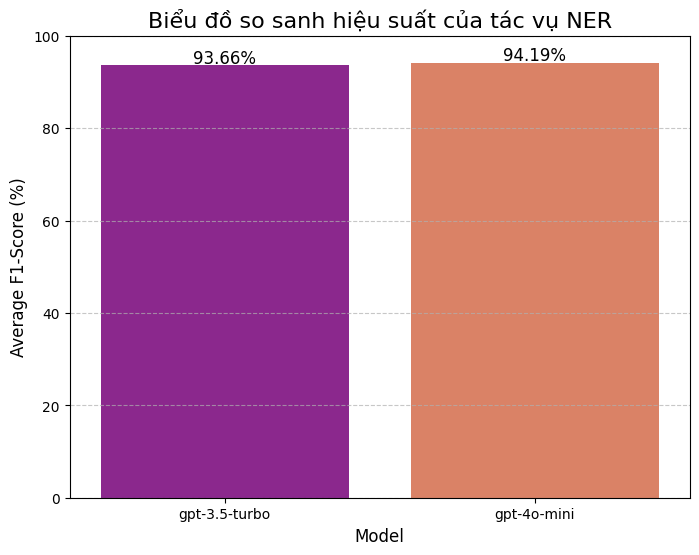

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ner_data = {
    'Experiment': [
        'English Prompt (Zero-shot)', 'Persian Prompt (Zero-shot)',
        'English Prompt (1-shot)', 'Persian Prompt (1-shot)',
        'English Prompt (3-shot)', 'Persian Prompt (3-shot)'
    ] * 2,
    'Model': [
        'gpt-3.5-turbo'] * 6 + ['gpt-4o-mini'] * 6
    ,
    'F1-Score': [
        # gpt-3.5-turbo scores (đã sắp xếp lại)
        92.65, 93.06, 94.10, 93.86, 94.26, 94.02,
        # gpt-4o-mini scores (lấy từ bảng của bạn, giả sử)
        93.85, 93.55, 94.50, 94.20, 94.68, 94.36
    ]
}

df_ner = pd.DataFrame(ner_data)

print("\n\n📈=============== BIỂU ĐỒ SO SÁNH HIỆU SUẤT TRUNG BÌNH (NER) ===============📈")

# Nhóm theo model và tính điểm F1-score trung bình
df_summary = df_ner.groupby('Model')['F1-Score'].mean().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='F1-Score', data=df_summary, hue='Model', palette='plasma', legend=False)

# Tùy chỉnh biểu đồ
plt.title('Biểu đồ so sanh hiệu suất của tác vụ NER', fontsize=16)
plt.ylabel('Average F1-Score (%)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị giá trị trên mỗi cột
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.show()

In [2]:
# Hiển thị bảng tóm tắt chi tiết
print("\n\n📊=============== BẢNG TÓM TẮT HIỆU SUẤT CHI TIẾT (NER) ===============📊")
# Tạo thứ tự mong muốn cho các hàng
prompt_order = [
    'English Prompt (Zero-shot)', 'Persian Prompt (Zero-shot)',
    'English Prompt (1-shot)', 'Persian Prompt (1-shot)',
    'English Prompt (3-shot)', 'Persian Prompt (3-shot)'
]
# Sắp xếp lại DataFrame theo thứ tự đã định
df_ner['Experiment'] = pd.Categorical(df_ner['Experiment'], categories=prompt_order, ordered=True)
df_ner = df_ner.sort_values('Experiment')

# Tạo bảng pivot
pivot_detailed = df_ner.pivot_table(index='Experiment', columns='Model', values='F1-Score')
print(pivot_detailed.to_markdown(floatfmt=".2f"))



📊=============== BẢNG TÓM TẮT HIỆU SUẤT CHI TIẾT (NER) ===============📊
| Experiment                 |   gpt-3.5-turbo |   gpt-4o-mini |
|:---------------------------|----------------:|--------------:|
| English Prompt (Zero-shot) |           92.65 |         93.85 |
| Persian Prompt (Zero-shot) |           93.06 |         93.55 |
| English Prompt (1-shot)    |           94.10 |         94.50 |
| Persian Prompt (1-shot)    |           93.86 |         94.20 |
| English Prompt (3-shot)    |           94.26 |         94.68 |
| Persian Prompt (3-shot)    |           94.02 |         94.36 |


C:\Users\GiaHyTran\AppData\Local\Temp\ipykernel_15744\1455105042.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_detailed = df_ner.pivot_table(index='Experiment', columns='Model', values='F1-Score')
